In [1]:
# !pip install -q pandas
# pip install -q matplotlib
# !pip install -q scikit-learn

# Qini-кривая и оценка качества офлайн

## Шаг 1: Сбор данных

Предположим, у вас есть данные для 100 пользователей:
- 50 пользователей получили рекламное предложение (группа воздействия).
- 50 пользователей не получили предложение (контрольная группа).

In [2]:
import pandas as pd
import numpy as np

# генерация данных для 100 пользователей
np.random.seed(42)
n = 100
treatment = np.array([1]*50 + [0]*50)
outcome = np.concatenate([np.random.choice([1, 0], p=[0.2, 0.8], size=50),
                          np.random.choice([1, 0], p=[0.1, 0.9], size=50)])
uplift_prediction = np.random.rand(n)

# создание DataFrame
data = {
    'user_id': range(1, n+1),
    'treatment': treatment,  # получение рекламных предложений
    'outcome': outcome,      # полученная реакция
    'uplift_prediction': uplift_prediction
}

df = pd.DataFrame(data)
print(df.head())

   user_id  treatment  outcome  uplift_prediction
0        1          1        0           0.031429
1        2          1        0           0.636410
2        3          1        0           0.314356
3        4          1        0           0.508571
4        5          1        1           0.907566


In [9]:
np.random.choice([1, 0], p=[0.2, 0.8], size=50).sum()

np.int64(11)

In [10]:
np.random.choice([1, 0], p=[0.1, 0.9], size=50).sum()

np.int64(6)

## Шаг 2: Сортировка данных по uplift_prediction

In [4]:
# сортировка данных по uplift_prediction
df = (
    df.sort_values(by='uplift_prediction', ascending=False)
    .reset_index(drop=True)
)
print(df.head())

   user_id  treatment  outcome  uplift_prediction
0       55          0        0           0.985650
1       40          1        0           0.971782
2       41          1        1           0.962447
3       35          1        0           0.942910
4       79          0        0           0.936730


## Шаг 3: Инициализация переменных для расчёта CGain и Random

In [5]:
# инициализация переменных
nt = 0   # число точек, на которых было воздействие до заданной точки
nt_1 = 0 # число точек, на которых были воздействия и реакция пользователя
nc = 0   # число точек, на которых не было воздействие до заданной точки (c — control). 
nc_1 = 0 # число точек, на которых не было воздействия и реакции пользователя.
cgain = [] # точка Qini-кривой, рассчитанная на заданном объекте выборк
random = [] # результат применения случайной модели
optimum = [] # максимальное значение uplift, которое мы можем получить на выборке.
incremental_purchases = 0 # добавленные покупки
opt_incremental_purchases = df['outcome'].sum() # максимально добавленные покупки

In [7]:
opt_incremental_purchases

np.int64(22)

## Шаг 4: Расчёт CGain, Random и Optimum

In [6]:
# расчёт CGain, Random и Optimum
for i, row in df.iterrows():
    if row['treatment'] == 1:
        nt += 1
        if row['outcome'] == 1:
            nt_1 += 1
            incremental_purchases += 1
    else:
        nc += 1
        if row['outcome'] == 1:
            nc_1 += 1

    cgain.append(incremental_purchases)
    random.append(opt_incremental_purchases * (i + 1) / len(df))
    optimum.append(min(opt_incremental_purchases, (i + 1) * 1.0))

## Шаг 5: Расчёт метрик

In [11]:
from sklearn.metrics import auc

# расчёт площади под кривыми
qini_auc = auc(range(1, len(cgain) + 1), cgain)
random_auc = auc(range(1, len(random) + 1), random)

# расчёт Qini Score
qini_score = qini_auc - random_auc

# вывод Qini Score
print(f'Qini Score: {qini_score}') 

Qini Score: -264.3900000000001


## Шаг 6: Построение графика

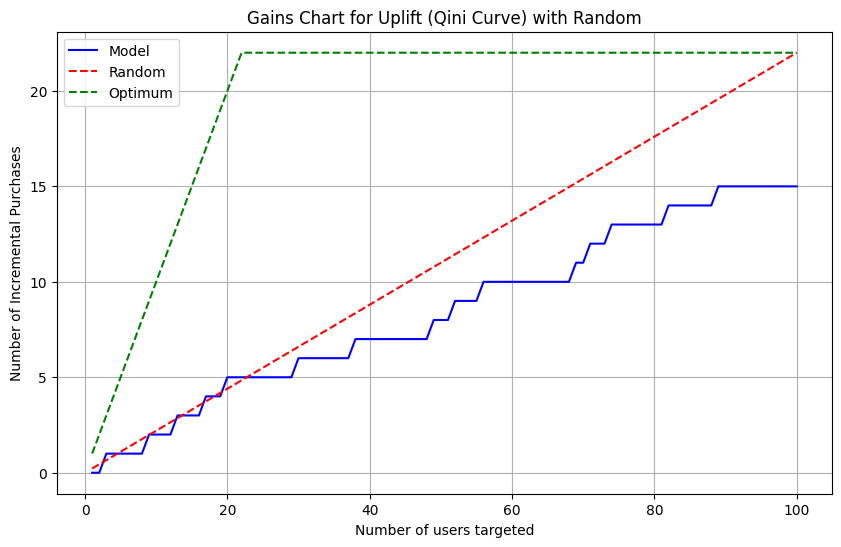

In [12]:
import matplotlib.pyplot as plt

# построение графиков
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cgain) + 1), cgain, label='Model', color='blue')
plt.plot(range(1, len(random) + 1), random, label='Random', color='red', linestyle='--')
plt.plot(range(1, len(optimum) + 1), optimum, label='Optimum', color='green', linestyle='--')
plt.xlabel('Number of users targeted')
plt.ylabel('Number of Incremental Purchases')
plt.title('Gains Chart for Uplift (Qini Curve) with Random')
plt.legend()
plt.grid(True)
plt.show()

## Задание

Ниже приведён код для отрисовки Qini-кривой. Дополните его и посчитайте Qini Score (площадь под кривой). 

Данные можете взять отсюда: `https://storage.yandexcloud.net/mle-data/sprint-5/discountuplift.csv`.

В данном датасете нас интересуют 2 колонки: `uplift_score` и `target_class`.

Расшифровка `target_class`:

- `0` — контрольная выборка, не купили товар ($y_c=0$, в наших терминах)
- `1` — контрольная выборка, купили товар ($y_c=1$, в наших терминах)
- `2` — выборка с воздействием (скидка), не купили товар ($y_t=0$, в наших терминах);
- `3` — выборка с воздействием (скидка), купили товар ($y_t=1$, в наших терминах).


In [13]:
# !mkdir datasets
# !wget https://storage.yandexcloud.net/mle-data/sprint-5/discountuplift.csv
# !mv discountuplift.csv datasets

In [20]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# загружаем DataFrame
discount = pd.read_csv("datasets/discountuplift.csv", sep="\t")
discount.sample(3, random_state=42)

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
9948,1,186.66,0,1,1,1,1,0,0,0,0,1,0.417925,0.166987,0.279740,0.135348,0.081161,2
2002,8,508.14,1,1,1,1,0,1,0,0,1,0,0.528632,0.061418,0.308849,0.101101,0.285057,2
3045,9,286.62,0,1,1,1,0,0,1,0,0,1,0.567822,0.022656,0.348541,0.060981,0.221080,2


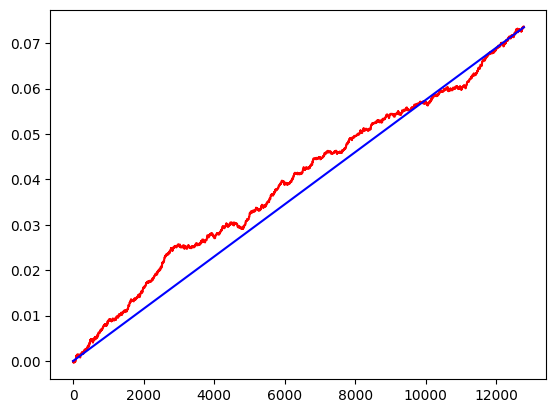

np.float64(33.22356)

In [70]:
# реализуем подсчёт Qini Score:
def qini_df(df):
    # 1. Отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values(by='uplift_score', ascending=False).reset_index(drop=True) # Ваш код здесь
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = ranked['n_t1/nt'] - ranked['n_c1/nc'] # Ваш код здесь
    # добавим случайную кривую
    end_point = ranked['uplift'].tail(1).values[0]
    ranked['random_uplift'] = np.linspace(0, end_point, ranked.shape[0]) # Ваш код здесь
    ranked["n"] = np.arange(ranked.shape[0]) # Ваш код здесь
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

qini_df(discount).round(5)

Это значит, что ваша модель лучше модели случайного воздействия (Qini Score положительный) — Baseline для других моделей создан. 

Итак, вы разобрались, как оценивать офлайн-качество uplift-моделей по их предсказанию. Дальше мы расскажем о том, как собрать выборку для правильной оценки качества, а также о том, как проводить A/B-тесты онлайн в случае uplift-моделирования.

# A/B-тесты и оценка качества онлайн
(Пример проведения A/B-теста для uplift-моделирования)

## Шаг 1: Определение цели и параметров теста
Предположим, что цель теста — увеличить количество поездок в сервисе такси после выдачи скидок.

- Цель: увеличение количества поездок.
- Метрики: количество поездок, средний чек, общий доход.
- Период: две недели.

## Шаг 2: Разделение аудитории
Аудитория делится на две группы случайным образом.

- Контрольная группа: не получает скидки.
- Экспериментальная группа: получает скидки.

In [3]:
import pandas as pd
import numpy as np

# загрузим данные пользователей
data = pd.read_csv(FILENAME)

# добавим колонку с группой (контрольная или экспериментальная)
np.random.seed(42)  # для воспроизводимости результатов
data['group'] = np.random.choice(['control', 'experiment'], size=len(data))

# сохраним контрольную и экспериментальную группы в отдельные переменные
control_group = data[data['group'] == 'control']
experiment_group = data[data['group'] == 'experiment']

## Шаг 3: Предоставление версий элемента
- Контрольная группа: видит стандартные цены без скидок.
- Экспериментальная группа: видит скидки на поездки.

In [5]:
# добавим колонку с информацией о скидках
data['discount'] = np.where(data['group'] == 'experiment', True, False)

# проверим результат
print(data.head())

## Шаг 4: Сбор данных

Собираются данные о количестве поездок, их стоимости, а также другие релевантные метрики в обеих группах.

In [ ]:
# создадим DataFrame для хранения результатов теста
results = pd.DataFrame(columns=['user_id', 'group', 'num_rides', 'total_spent'])

# симуляция данных для каждой группы
# для простоты примера мы используем случайные данные
for _, row in data.iterrows():
    num_rides = np.random.poisson(lam=5 if row['discount'] else 3)  # предполагаем, что скидки увеличивают среднее количество поездок
    total_spent = num_rides * (20 if row['discount'] else 25)  # допустим, что средняя стоимость поездки отличается
    
    results = results.append({
        'user_id': row['user_id'],
        'group': row['group'],
        'num_rides': num_rides,
        'total_spent': total_spent
    }, ignore_index=True)

# сохраним результаты
results.to_csv('ab_test_results.csv', index=False)

## Шаг 5: Анализ данных и интерпретация результатов

После завершения теста анализируются собранные данные:
- сравниваются результаты контрольной и экспериментальной групп;
- оценивается, насколько значимо увеличилось количество поездок в экспериментальной группе;
- применяются статистические тесты для определения значимости различий.


In [ ]:
from scipy import stats

# загрузим результаты теста
results = pd.read_csv('ab_test_results.csv')

# группируем данные
grouped_results = results.groupby('group').agg({
  'num_rides': ['mean', 'std', 'count'],
  'total_spent': ['mean', 'std', 'count']
})

print(grouped_results)

# сравниваем средние значения количества поездок
control_rides = results[results['group'] == 'control']['num_rides']
experiment_rides = results[results['group'] == 'experiment']['num_rides']

t_stat, p_value = stats.ttest_ind(control_rides, experiment_rides)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

# оцениваем, насколько значимо увеличилось количество поездок в экспериментальной группе
if p_value < 0.05:
  print("Различие в количестве поездок между контрольной и экспериментальной группами статистически значимо.")
else:
  print("Различие в количестве поездок между контрольной и экспериментальной группами не является статистически значимым.")

Этот пример показывает ключевые этапы проведения A/B-теста для uplift-моделирования.
Сам же процесс помогает оценить эффективность маркетинговых воздействий и использовать полученные данные для обучения uplift-моделей.

# S-learner

Ваша задача — научиться выдавать скидки так, чтобы повысить вероятность покупки товара. 

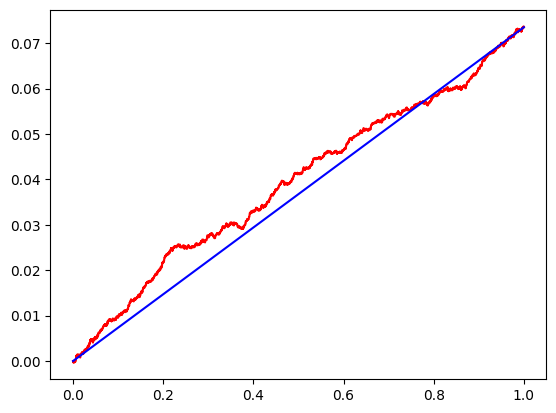

np.float64(33.18176)

In [10]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("datasets/discountuplift.csv", sep="\t")

# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания 
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем Qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

qini_df(df)

## Задание 1 из 4

Первое, что нужно сделать, — явно выделить колонки с целевой переменной, факторами и целевым воздействием. Напомним значения целевой переменной: 
- `0` — контрольная выборка, не купили товар ($y_c=0$);
- `1` — контрольная выборка, купили товар ($y_c=1$);
- `2` — выборка с воздействием (скидка), не купили товар ($y_t=0$);
- `3` — выборка с воздействием (скидка), купили товар ($y_t=1$).

Преобразуйте исходный датафрейм:
- добавьте колонку `old_target` — колонка, которая принимает значение 1, если была покупка, и 0 в противном случае;
- выделим колонки с факторами и колонку с фактом «целевого воздействия» — выдачи скидки.

In [46]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("datasets/discountuplift.csv", sep="\t")

In [49]:
# ваш код здесь (таргет — факт покупки)
df['old_target'] = 0
df.loc[ranked.target_class.isin([1, 3]),'old_target'] = 1

In [50]:
feature_cols = [
    'recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
    'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
    'channel_Multichannel', 'channel_Phone', 'channel_Web'
]

In [58]:
target_col = 'old_target' # имя колонки с целевой переменной
treatment_col = 'treatment'

In [61]:
df[df[target_col] == 1].shape[0]

1878

## Задание 2 из 4

Теперь разбейте выборку на тренировочную и тестовую.
Условия: `random_state=1`, размер тестовой выборки — 25%, разбиение стратифицированное по колонке с фактом целевого воздействия и с целевой переменной.

In [67]:
from sklearn.model_selection import train_test_split

# разбейте выборку на тренировочную и тестовую
df_train, df_test = train_test_split(
    df, stratify=df.old_target, test_size=0.25, random_state=1
)

In [68]:
df_train.shape, df_test.shape

((9588, 19), (3196, 19))

In [78]:
# Чему равна доля значений 1 в целевой переменной из тренировочного датасета? 
round(df_train.value_counts(target_col, normalize=True), 5)

old_target
0    0.85305
1    0.14695
Name: proportion, dtype: float64

In [79]:
0.14695

0.14695

## Задание 3 из 4

Теперь обучите S-learner (в данном случае это логистическая регрессия).

In [84]:
from sklearn.linear_model import LogisticRegression

# создайте логистическую регрессию с random_state=1
s_learner = LogisticRegression(random_state=1)
s_learner.fit(
    X=df_train[feature_cols + [treatment_col]],
    y=df_train[target_col]
)

# посчитайте intercept
s_learner.intercept_

array([-1.40435315])

In [87]:
# Чему равен intercept в обученной модели? Ответ округлите до пятого знака после запятой.
round(s_learner.intercept_[0], 5)

np.float64(-1.40435)

## Задание 4 из 4

Измерьте качество модели при помощи Qini Score. В прекоде к этому заданию мы затронем все шаги — в будущем же вы сможете писать более короткий код инференса модели. 

In [134]:
# предскажем вероятность покупки, если скидка есть
df_test[treatment_col] = df_test.loc[df_test.target_class.isin([2, 3]), treatment_col] = 1
df_test['yes_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,1]

# предскажите вероятность покупки, если скидки нет 
df_test.loc[df_test.target_class.isin([0, 1]), treatment_col] = 0
df_test['no_treatment'] = s_learner.predict_proba(df_test[feature_cols+[treatment_col]])[:,0] # ваш код здесь

# посчитаем uplift на объектах тестовой выборки
uplift_vals = df_test.apply(
    lambda row: row['yes_treatment'] - row['no_treatment'],
    axis=1
)
df_test['uplift_score'] = uplift_vals

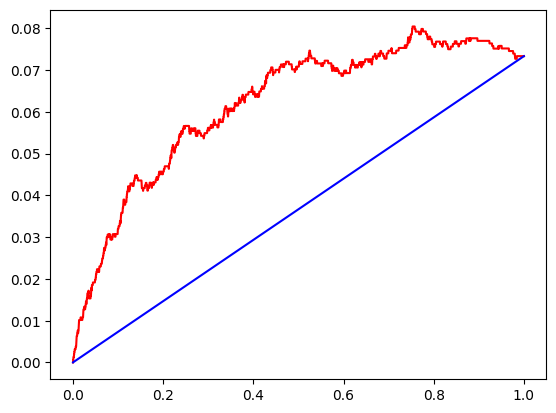

np.float64(79.74536)

In [136]:
# посчитаем Qini Score по нашему датасету 
ranked = df_test.sort_values("uplift_score", ascending=False)

N_c = sum(ranked['target_class'] <= 1)
N_t = sum(ranked['target_class'] >= 2)

# посчитаем в отсортированном датафрейме основные показатели, 
# которые используются при расчёте Qini Score
ranked['n_c1'] = 0
ranked['n_t1'] = 0
ranked.loc[ranked.target_class == 1,'n_c1'] = 1
ranked.loc[ranked.target_class == 3,'n_t1'] = 1
ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t

# посчитаем Qini-кривую и случайную прямую под ней
ranked['uplift'] = ranked['n_t1/nt'] - ranked['n_c1/nc']
# добавим случайную кривую
ranked['random_uplift'] = ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1]

ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
# немного кода для визуализации
plt.plot(ranked['n'], ranked['uplift'], color='r')
plt.plot(ranked['n'], ranked['random_uplift'], color='b')
plt.show()

round((ranked['uplift'] - ranked['random_uplift']).sum(), 5)